## Libs

In [2]:
library(readxl)
library(vegan)
library(ggplot2)
library(plotly)
library(impute)
install.packages("factoextra")
library(factoextra)
library(psych)
library(ggforce)
library(rstatix)


## EDA and preprocessing

In [3]:
df <- read.delim("Sleepy lizard.tsv")
df <- df %>% select(Treatment, Habitat, Connectivity, Tot_WBC, Het_ABS, Lym_ABS, `H.L.Ratio`, Mon_ABS, OthG_ABS, LBSI)
head(df)


,Treatment,Habitat,Connectivity,Tot_WBC,Het_ABS,Lym_ABS,H.L.Ratio,Mon_ABS,OthG_ABS,LBSI
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
1,1,1,5,14648,10400,1465,7.1,293,2783,0.033123
2,1,1,5,6957,3200,557,5.8,139,2922,0.001101
3,1,1,5,13333,7200,1733,4.2,933,3333,0.014861
4,1,1,5,12698,8000,1143,7.0,127,2286,-0.073275
5,1,1,5,4545,2000,1727,1.2,636,636,-0.009629
6,1,1,5,5143,3600,257,14.0,51,1286,-0.018708


In [4]:
# Checking that the types in df are OK.
names_and_types <- sapply(df, function(x) paste(class(x), collapse = ","))

names_and_types_df <- data.frame(
    Name = names(df),
    Type = names_and_types
)
names_and_types_df


,Name,Type
,<chr>,<chr>
Treatment,Treatment,integer
Habitat,Habitat,integer
Connectivity,Connectivity,integer
Tot_WBC,Tot_WBC,integer
Het_ABS,Het_ABS,integer
Lym_ABS,Lym_ABS,integer
H.L.Ratio,H.L.Ratio,numeric
Mon_ABS,Mon_ABS,integer
OthG_ABS,OthG_ABS,integer


In [5]:
# changing int to factor variables in the dataframe
df$Treatment <- as.factor(df$Treatment)
df$Habitat <- as.factor(df$Habitat)
df$Connectivity <- as.factor(df$Connectivity)


In [6]:
# Checking that the types in df are OK.
names_and_types <- sapply(df, function(x) paste(class(x), collapse = ","))

names_and_types_df <- data.frame(
    Name = names(df),
    Type = names_and_types
)
names_and_types_df


,Name,Type
,<chr>,<chr>
Treatment,Treatment,factor
Habitat,Habitat,factor
Connectivity,Connectivity,factor
Tot_WBC,Tot_WBC,integer
Het_ABS,Het_ABS,integer
Lym_ABS,Lym_ABS,integer
H.L.Ratio,H.L.Ratio,numeric
Mon_ABS,Mon_ABS,integer
OthG_ABS,OthG_ABS,integer


In [7]:
summary(df)


 Treatment Habitat Connectivity    Tot_WBC         Het_ABS     
 1:30      1:64    1:29         Min.   : 1714   Min.   : 1200  
 2:92      2:27    3:29         1st Qu.: 3576   1st Qu.: 2000  
           3:31    4:22         Median : 4880   Median : 2400  
                   5:42         Mean   : 6964   Mean   : 3805  
                                3rd Qu.: 7255   3rd Qu.: 3600  
                                Max.   :74667   Max.   :56000  
    Lym_ABS          H.L.Ratio         Mon_ABS          OthG_ABS       
 Min.   :  257.0   Min.   : 0.800   Min.   :   0.0   Min.   :    0.00  
 1st Qu.:  939.8   1st Qu.: 1.425   1st Qu.: 153.0   1st Qu.:   60.75  
 Median : 1248.0   Median : 1.900   Median : 303.5   Median :  153.50  
 Mean   : 1489.2   Mean   : 2.907   Mean   : 487.5   Mean   :  829.88  
 3rd Qu.: 1712.5   3rd Qu.: 2.775   3rd Qu.: 661.5   3rd Qu.:  591.25  
 Max.   :10971.0   Max.   :25.000   Max.   :3135.0   Max.   :10453.00  
      LBSI           
 Min.   :-1.362e-01  
 1st

In [8]:
# df with blood data
blood_df <- df %>% select(-Treatment, -Habitat, -Connectivity)
head(blood_df)


,Tot_WBC,Het_ABS,Lym_ABS,H.L.Ratio,Mon_ABS,OthG_ABS,LBSI
,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
1,14648,10400,1465,7.1,293,2783,0.033123
2,6957,3200,557,5.8,139,2922,0.001101
3,13333,7200,1733,4.2,933,3333,0.014861
4,12698,8000,1143,7.0,127,2286,-0.073275
5,4545,2000,1727,1.2,636,636,-0.009629
6,5143,3600,257,14.0,51,1286,-0.018708


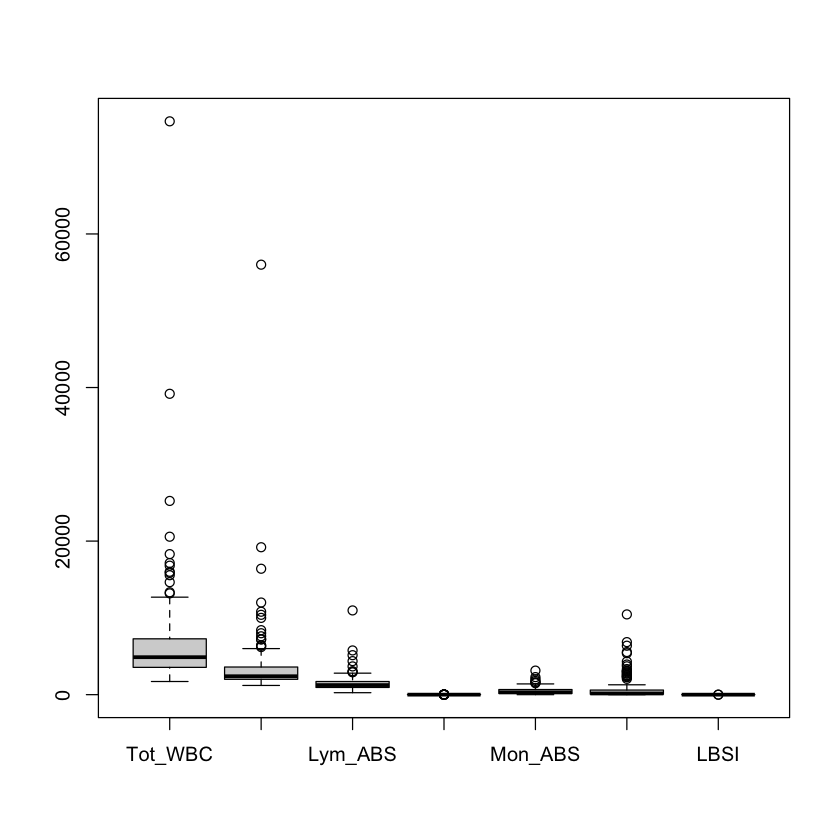

In [9]:
boxplot(blood_df)


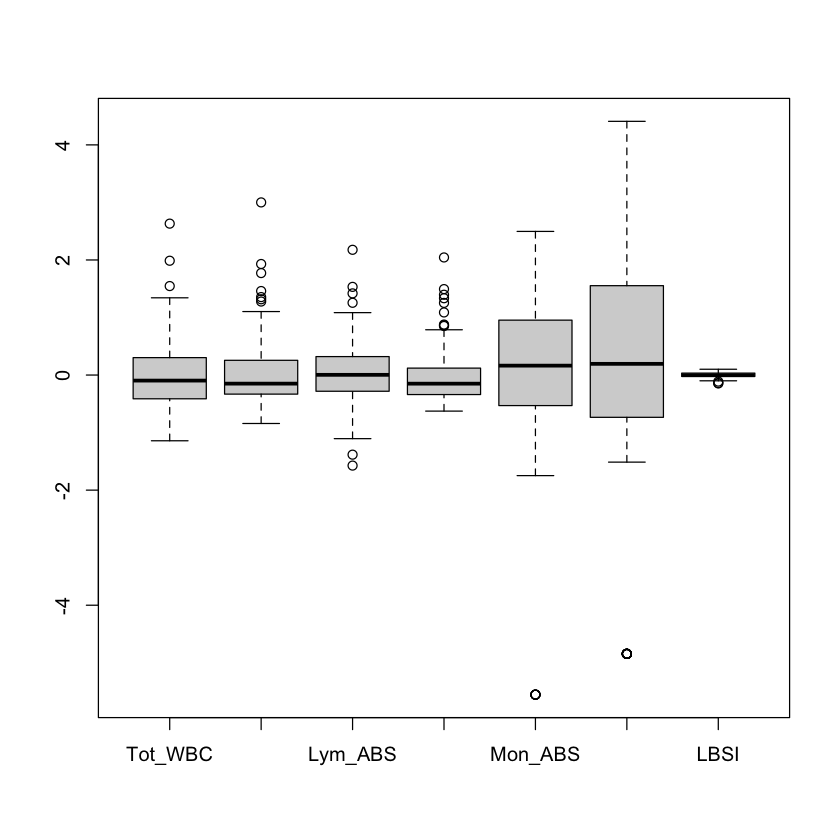

In [10]:
# norm + log transformation
blood_df <- scale(log(blood_df + 1), scale = FALSE)
boxplot(blood_df)


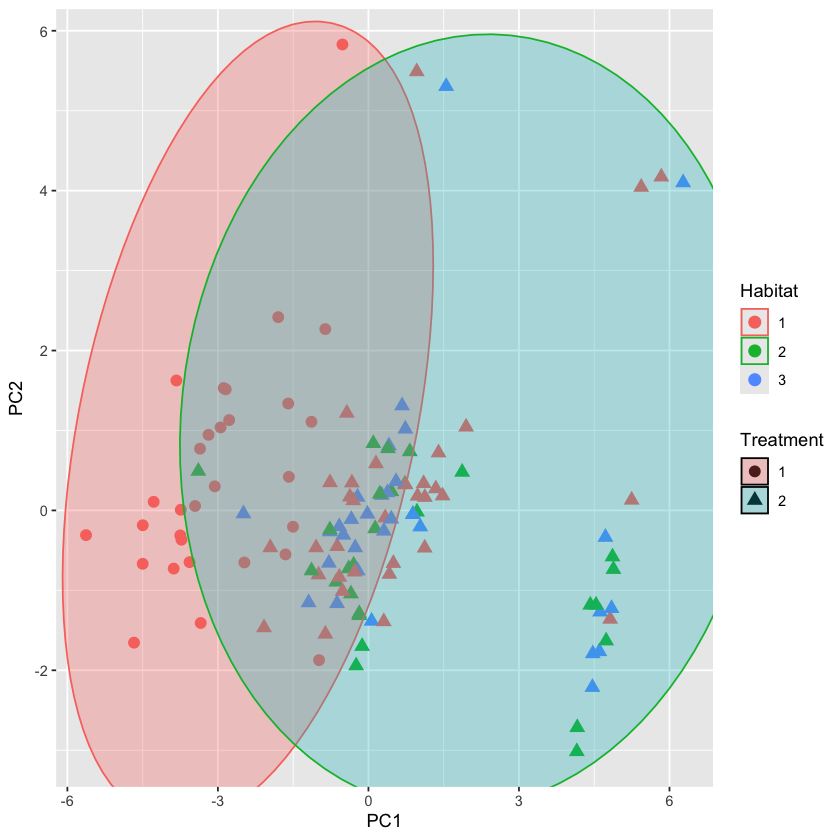

In [11]:
# PCA analysis
blood_pca <- prcomp(blood_df)$x %>%
  as.data.frame() %>%
  select(PC1, PC2) %>%
  mutate(Treatment = df$Treatment, Habitat = df$Habitat)

ggplot(blood_pca, aes(x = PC1, y = PC2, shape = Treatment, col = Habitat)) +
  geom_point(size = 3) +
  geom_mark_ellipse(aes(col = Treatment, fill = Treatment))


Prior to applying perMANOVA method, we need to ensure there is no significant difference in dispersion between groups in factors of interest.

Analysis of Variance Table

Response: Distances
           Df Sum Sq Mean Sq F value Pr(>F)
Groups      1   0.51 0.51117  0.1849  0.668
Residuals 120 331.80 2.76500               


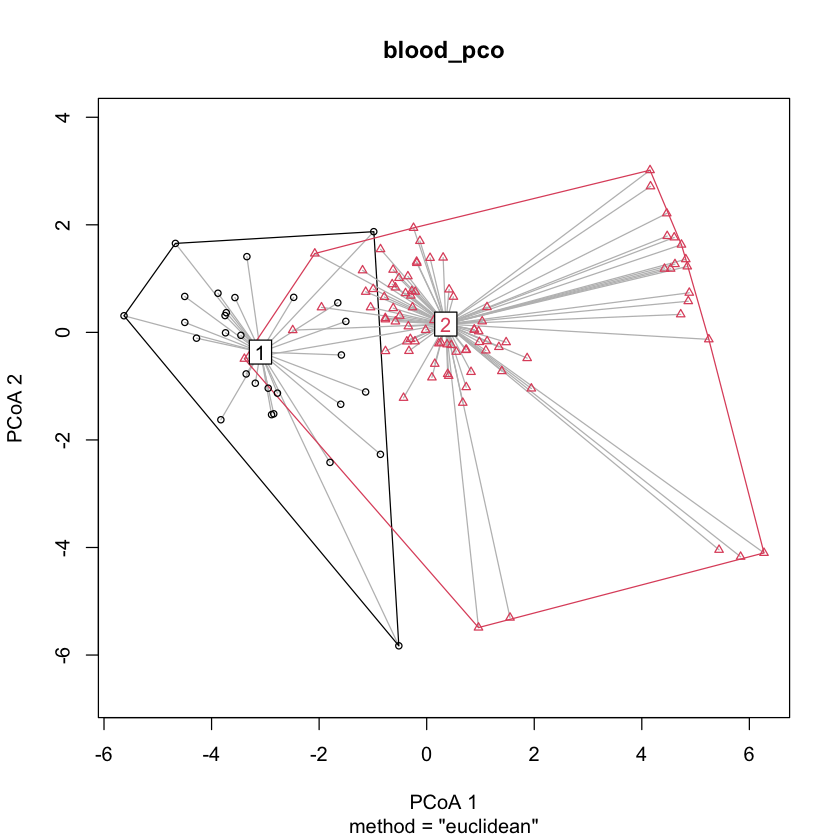

Analysis of Variance Table

Response: Distances
           Df Sum Sq Mean Sq F value Pr(>F)
Groups      2   5.45  2.7245  0.9024 0.4083
Residuals 119 359.27  3.0191               


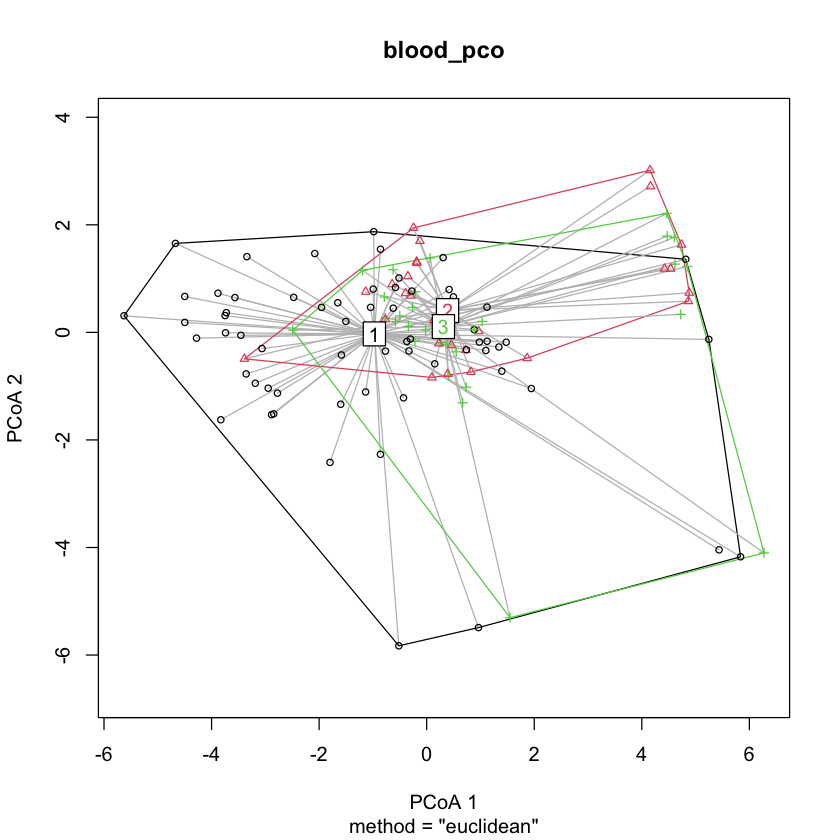

Analysis of Variance Table

Response: Distances
           Df Sum Sq Mean Sq F value Pr(>F)
Groups      3   5.86  1.9533  0.6613 0.5774
Residuals 118 348.53  2.9536               


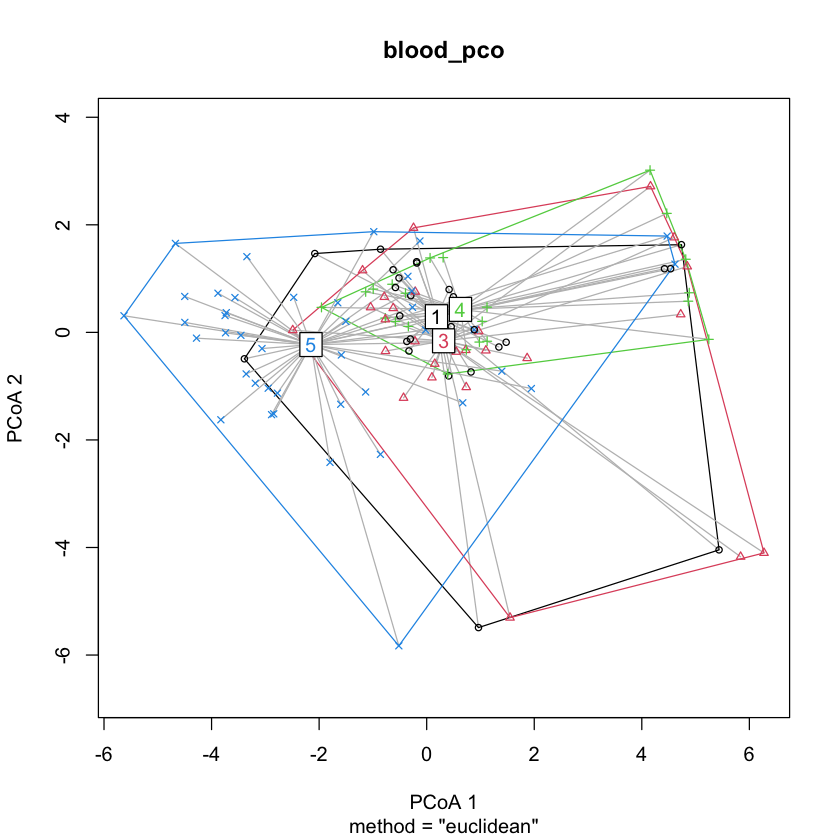

In [12]:
column_names <- c("Treatment", "Habitat", "Connectivity")

for (col_name in column_names) {
    blood_dist <- vegdist(blood_df, method = "euclidean")
    blood_pco <- betadisper(blood_dist, df[[col_name]])
    plot(blood_pco)
    print(anova(blood_pco))
}


There is no significant difference of dispersion of Habitat, Connectivity and Treatment between groups.

## perMANOVA

### Task 1.a

Does the blood composition of lizards from unmodified and heavily modified landscapes differ?

In [13]:
adonis2(blood_df ~ df$Treatment, method = "euclidean")


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
df$Treatment,1,355.8632,0.3017425,51.85637,0.001
Residual,120,823.4973,0.6982575,NA,NA
Total,121,1179.3605,1.0000000,NA,NA


### Task 1.b 

Check whether blood composition of lizards in different habitats differs between lizards from the highly modified landscape 

In [14]:
df_mod <- blood_df %>%
    as.data.frame() %>%
    filter(df$Treatment == 2)
habitat_mod <- subset(df, Treatment == 2)$Habitat


In [25]:
adonis2(df_mod ~ habitat_mod, method = "euclidean")


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
habitat_mod,2,14.96241,0.02243894,1.021453,0.408
Residual,89,651.84303,0.97756106,NA,NA
Total,91,666.80544,1.00000000,NA,NA


### Task 1.c

Test whether the degree of connectivity affects the blood composition of lizards from the highly modified landscape

In [26]:
connectivity_mod <- subset(df, Treatment == 2)$Connectivity
adonis2(df_mod ~ connectivity_mod, method = "euclidean")


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
connectivity_mod,3,19.21482,0.02881623,0.8703566,0.556
Residual,88,647.59062,0.97118377,NA,NA
Total,91,666.80544,1.00000000,NA,NA


### Task 2

Whether the blood composition of lizards from a highly modified landscape is affected by habitat type and degree of connectivity 

In [27]:
adonis2(df_mod ~ connectivity_mod + habitat_mod, method = "euclidean")


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
connectivity_mod,3,19.21482,0.02881623,0.8717068,0.512
habitat_mod,2,15.69828,0.02354252,1.0682612,0.380
Residual,86,631.89234,0.94764125,NA,NA
Total,91,666.80544,1.00000000,NA,NA


## Conclusions

Obtained statistics of perMANOVA analysis demonstrate that there is a statisitcally significant difference in blood composition of lizards from heavily transformed enviroment and ones from unaltered landscapes.

However, in terms of habitat type and connectivity, there is not significant disparity between the blood composition of lizards from heavily altered landscapes.

Although there is significant distance between subjects having different treatment, as indicated by PCA analysis, it is anticipated that in heavily modified lanscapes there are no pronounced clusters related to connectivity and/or habitat types. Therefore, treatment is most significant factor affecting blood composition of lizards.